# GNN example

### Reading in a polarizability dataset

Installing pytorch extension libraries is not entirely straightforward
```
$ pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
```

In [1]:
from pathlib import Path

import numpy as np
import torch
from tqdm import tqdm

import ramannoodle.io.vasp as vasp_io
from ramannoodle.io.io_utils import pathify_as_list
from ramannoodle.exceptions import InvalidFileException

import matplotlib
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["lines.linewidth"] = 1.5

chosen_device = 'cpu'
torch.set_default_device(chosen_device)

from torch.utils.data import DataLoader, random_split



In [2]:
from ramannoodle.polarizability.gnn import PolarizabilityDataset

def read_polarizability_dataset(
    filepaths: list[str] | list[Path],
) -> PolarizabilityDataset:
    """Read polarizability dataset from files."""
    filepaths = pathify_as_list(filepaths)
    lattices = []
    atomic_numbers_list = []
    positions_list = []
    polarizabilities = []
    for filepath in tqdm(filepaths):
        try:
            lattice, atomic_numbers, positions, polarizability = (
                vasp_io.outcar.read_structure_and_polarizability(filepath)
            )
        except InvalidFileException as exc:
            raise InvalidFileException(f"invalid file: {filepath}") from exc

        lattices.append(lattice)
        atomic_numbers_list.append(atomic_numbers)
        positions_list.append(positions)
        polarizabilities.append(polarizability)
    return PolarizabilityDataset(
        np.array(lattices),
        atomic_numbers_list,
        np.array(positions_list),
        np.array(polarizabilities),
    )

import glob

ref_dataset = read_polarizability_dataset("/Volumes/Untitled/TiO2_eps/ref/scratch/OUTCAR")

dataset = read_polarizability_dataset(
    list(glob.glob("/Volumes/Untitled/TiO2_eps/*ps*/scratch/OUTCAR"))
)
known_generator = torch.Generator(device=chosen_device).manual_seed(42)
train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [0.05, 0.05, 0.90], generator=known_generator
)

100%|██████████| 800/800 [00:12<00:00, 63.07it/s]


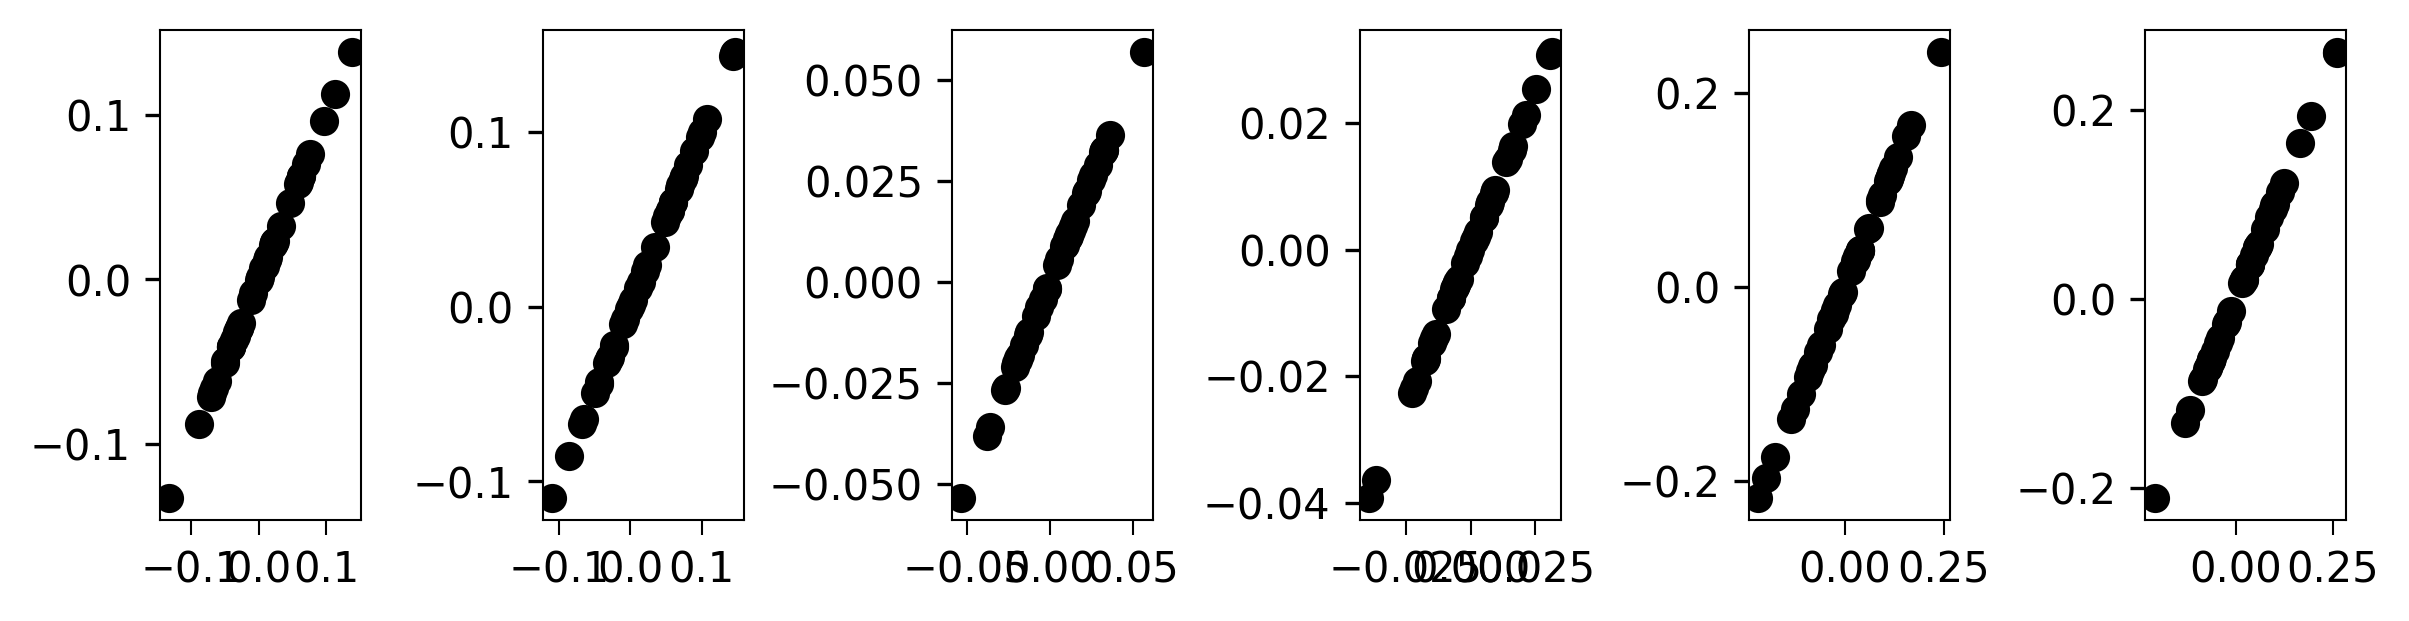

In [3]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()
loader = DataLoader(train_dataset, batch_size = 2)

for lattice, atomic_numbers, positions, true_polarizability  in loader:
    for i in range(6): 
        axis = axes[i]  # type: ignore
        axis.scatter(true_polarizability[:,i], true_polarizability[:,i], color="black")

In [10]:
from torch import Tensor
from ramannoodle.polarizability.gnn import PotGNN

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
validation_loader = DataLoader(validation_dataset, batch_size=50, shuffle=True) 

ref_structure = vasp_io.poscar.read_ref_structure("data/TiO2/POSCAR")

model = PotGNN(
    ref_structure,
    hidden_node_channels=5,
    hidden_edge_channels=10,
    num_layers=3,
    cutoff = 2,
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
model.to(chosen_device)

def train() -> tuple[float, float]:
    model.train()

    train_losses = []
    validation_losses = []
    
    for lattice, atomic_numbers, position, polarizability in train_loader:  
        out = model.forward(lattice, atomic_numbers, position)  
        loss = criterion(out, polarizability)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad() 
        train_losses.append(float(loss))

    model.eval()
    validation_losses = []
    for lattice, atomic_numbers, position, polarizability  in validation_loader:
        out = model.forward(lattice, atomic_numbers, position)  
        loss = criterion(out, polarizability)
        validation_losses.append(float(loss))
    
    return float(np.mean(train_losses)), float(np.mean(validation_losses))


In [11]:
torch.mean(dataset._scaled_polarizabilities, dim = 0)
torch.max(dataset._scaled_polarizabilities, dim = 0)
torch.min(dataset._scaled_polarizabilities, dim = 0)

torch.return_types.min(
values=tensor([-0.2629, -0.1922, -0.0934, -0.0582, -0.2942, -0.3637]),
indices=tensor([399, 653, 369, 103, 381, 586]))

In [12]:
training_losses = []
validation_losses = []

In [13]:
from tqdm import trange
print(len(train_dataset))
with trange(100) as t:
    for epoch in t:
        training_loss, validation_loss = train()
        t.set_postfix(training_loss=training_loss, validation_loss=validation_loss)
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)


40


100%|██████████| 100/100 [01:24<00:00,  1.19it/s, training_loss=5.57e-5, validation_loss=0.00237]


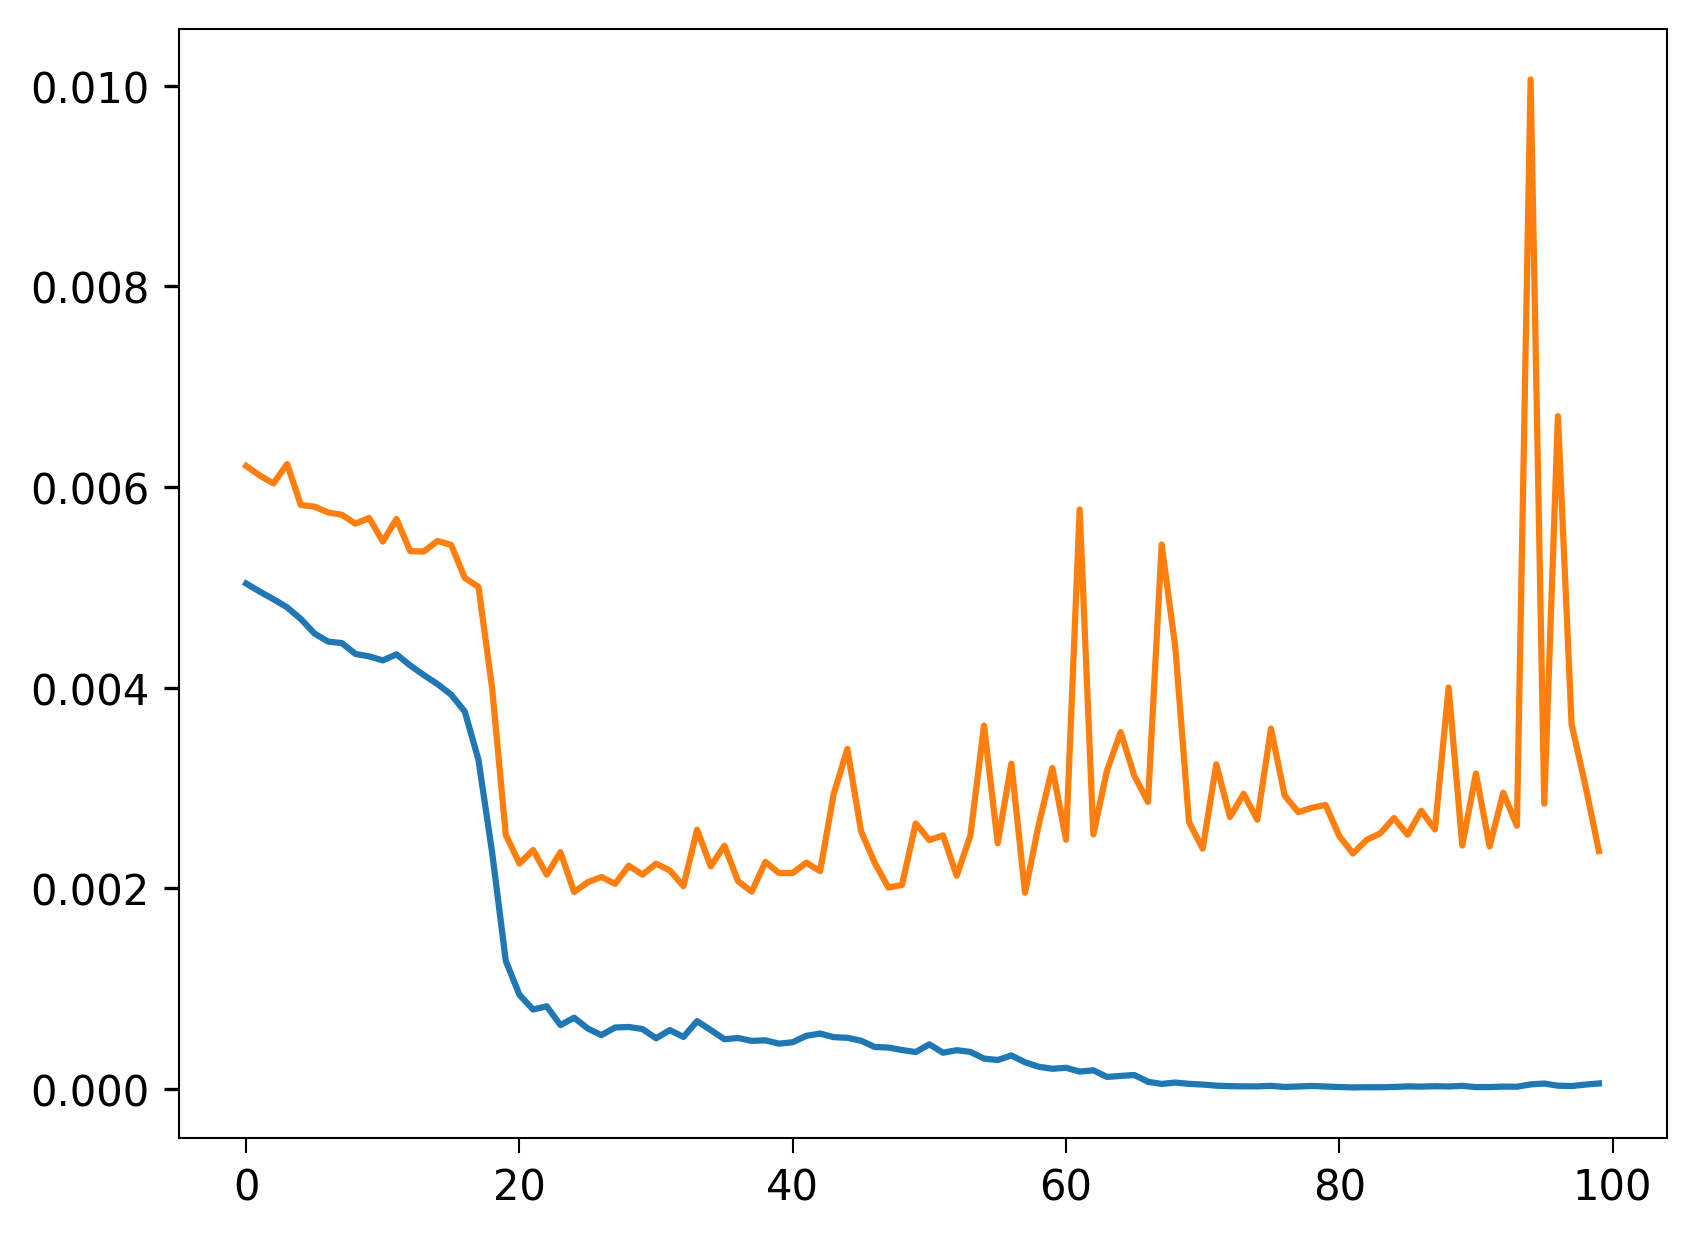

In [14]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(training_losses)
axis.plot(validation_losses)

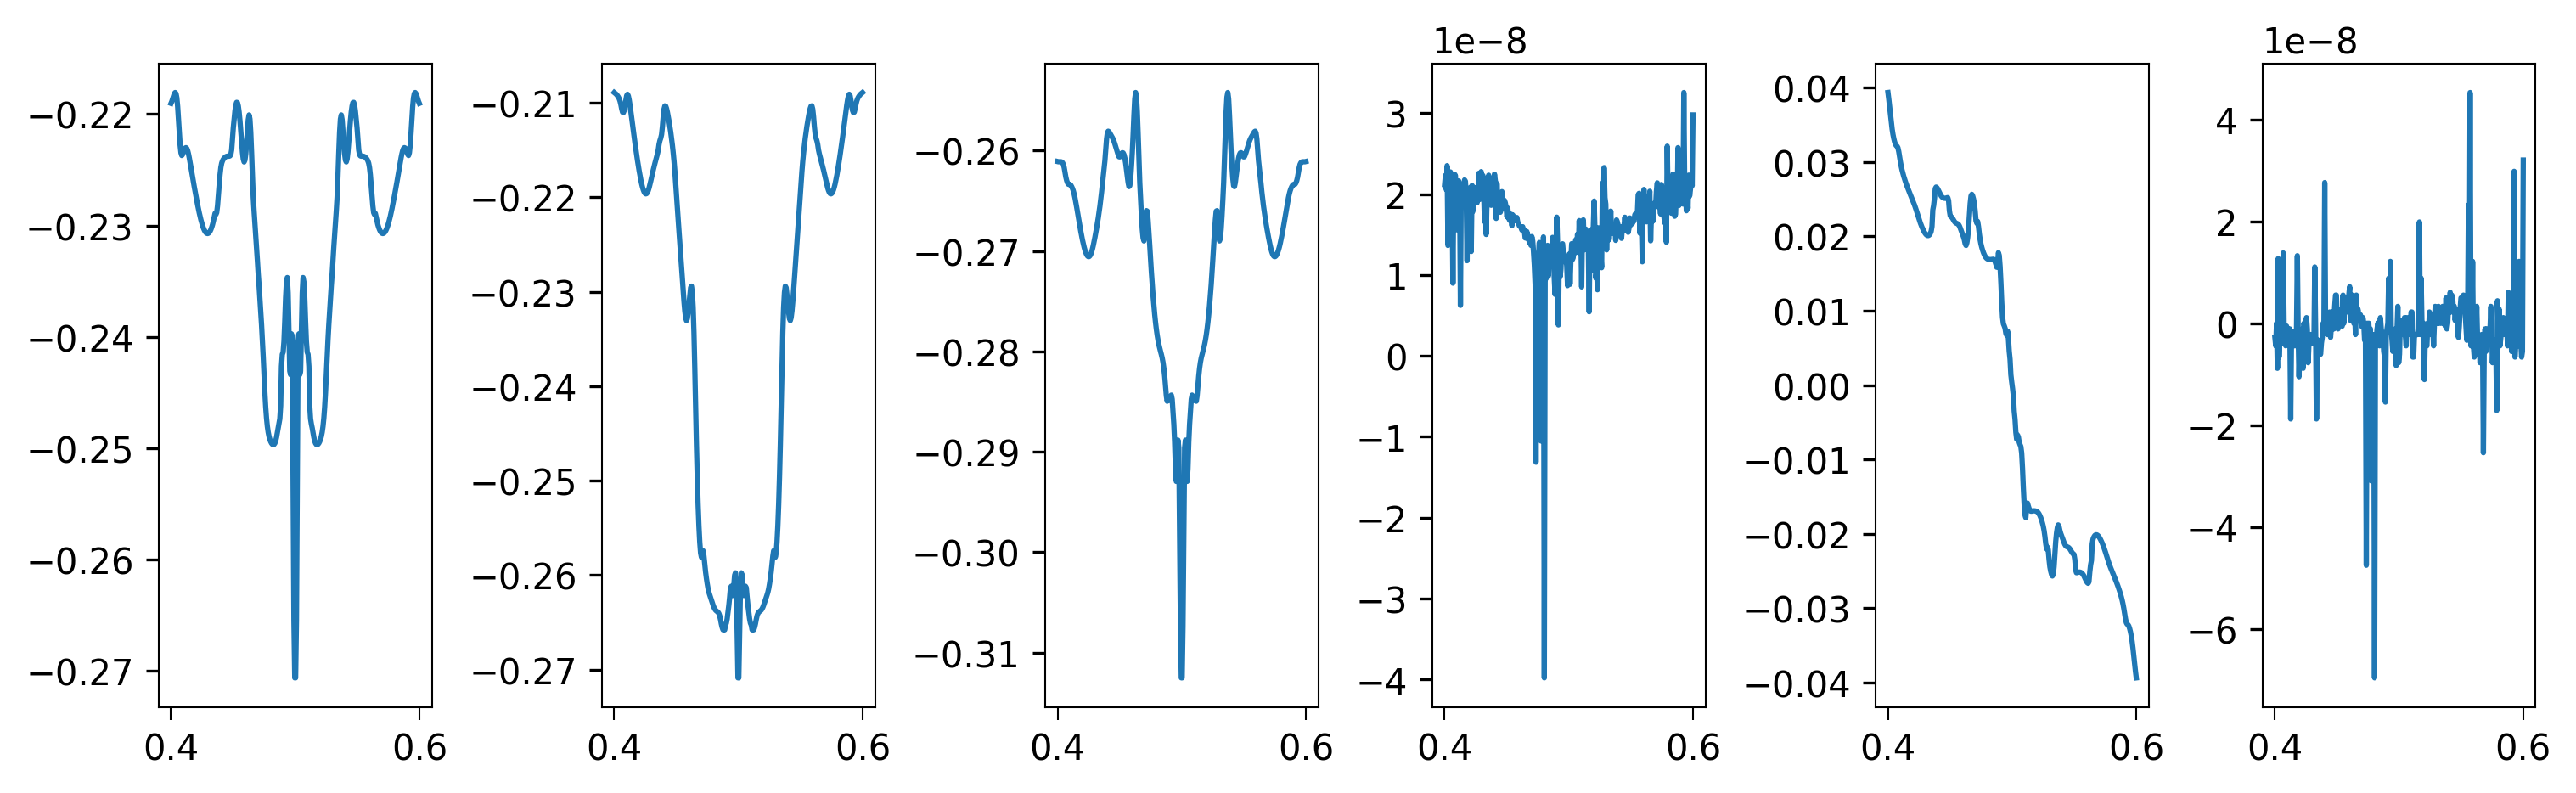

In [15]:
import ramannoodle.io.vasp as vasp_io
from torch import Tensor
from ramannoodle.polarizability.gnn import PotGNN

ref_structure = vasp_io.poscar.read_ref_structure("data/TiO2/POSCAR")
lattice = torch.tensor([ref_structure.lattice]).float()
atomic_numbers = torch.tensor([ref_structure.atomic_numbers], dtype=torch.int)
positions = torch.tensor([ref_structure.positions]).float()

ds = torch.linspace(0.40,0.60,300)
result = []
for d in ds:
    positions[0][4][0] = d
    result.append(model(lattice, atomic_numbers, positions)[0].detach().numpy())
result = np.array(result)

fig = plt.figure(constrained_layout=True, figsize=(10, 3))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()

for i in range(6): 
    axis = axes[i]  # type: ignore
    axis.plot(ds, result[:,i])
    #axis.set_yticks([])

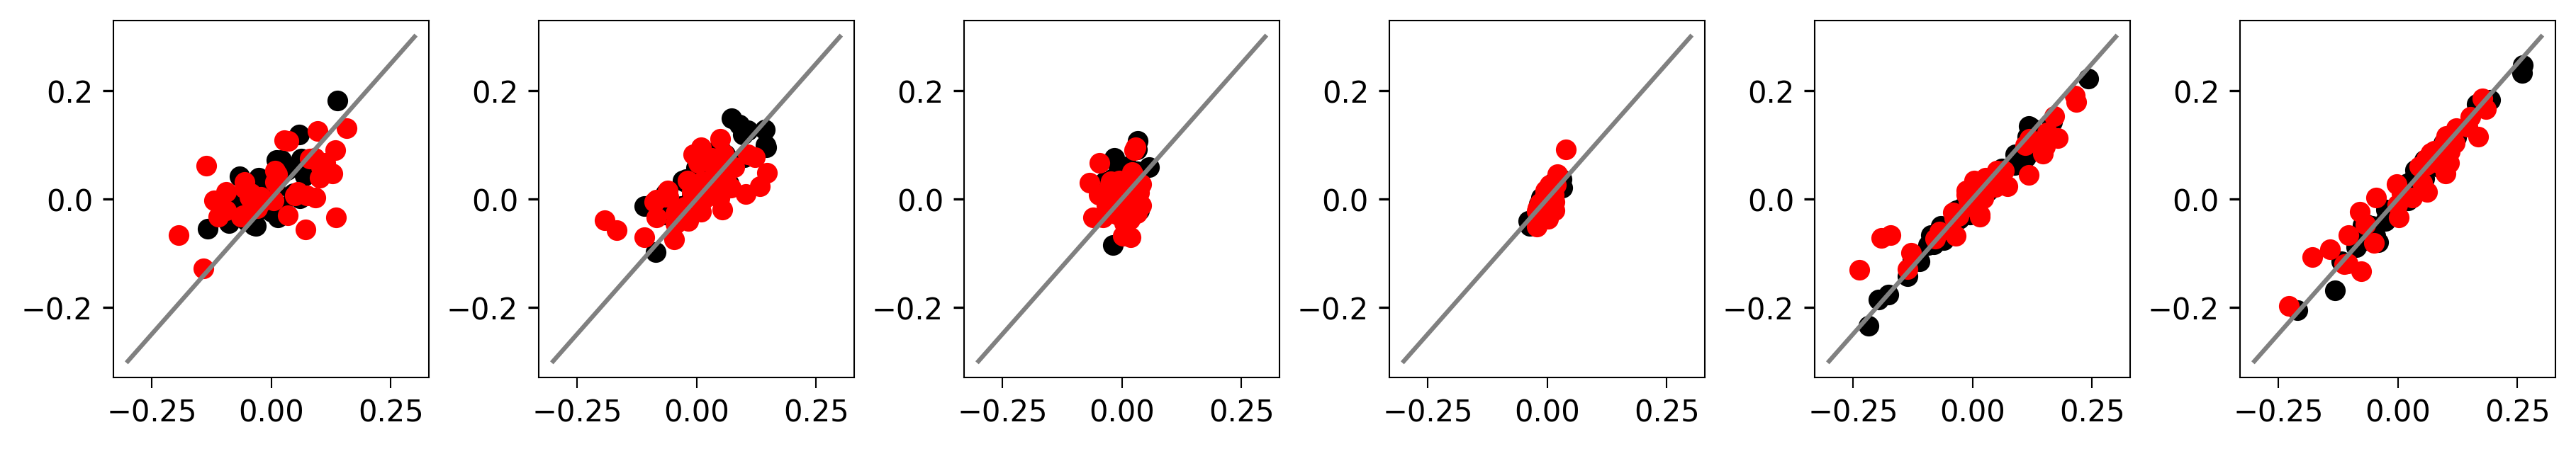

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(12, 2))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()
plot_train_loader = DataLoader(train_dataset, batch_size = 50)
plot_validation_loader = DataLoader(validation_dataset, batch_size = 50)

for i in range(6): 
    axis = axes[i]  # type: ignore
    for lattice, atomic_numbers, positions, true_polarizability  in plot_train_loader:
        predicted_polarizability = model(lattice, atomic_numbers, positions).detach().numpy()
        axis.scatter(
            true_polarizability[:,i], predicted_polarizability[:,i], color="black"
        )
    for lattice, atomic_numbers, positions, true_polarizability  in plot_validation_loader:
        predicted_polarizability = model(lattice, atomic_numbers, positions).detach().numpy()
        axis.scatter(
            true_polarizability[:,i], predicted_polarizability[:,i], color="red"
        )
    axis.set_aspect(1)

In [12]:
model.ref_distances.repeat((3,1)).size()

torch.Size([1296, 1])

In [ ]:
import networkx as nx
import torch_geometric.utils
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from ramannoodle.polarizability.gnn import _radius_graph_pbc
lattice, _, positions, _ = train_dataset[1]
plot_positions = {i: positions[i][0:2] for i, _ in enumerate(positions)}

edge_index, _, _ = _radius_graph_pbc(lattice.unsqueeze(0), positions.unsqueeze(0), cutoff = 2.5)
print(edge_index.size())
data = Data(x = positions, edge_index=edge_index)

g = torch_geometric.utils.to_networkx(data)
nx.draw(g, pos = plot_positions)

In [ ]:
for i in range(108):
    print(torch.sum(torch.where(torch.logical_or(edge_index[0] == i, edge_index[1] == i), 1, 0)))

In [18]:
import networkx as nx
import torch_geometric.utils
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
positions = torch.tensor([[0,0,0], [0,0.25,0.25], [0.75,0.75,0.75]])
plot_positions = {i: positions[i][0:2] for i, _ in enumerate(positions)}

edge_index = (  
    positions, r=2, max_num_neighbors=10
)
print(edge_index)
data = Data(x = positions, edge_index=edge_index)

g = torch_geometric.utils.to_networkx(data)
nx.draw(g, pos = plot_positions)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (4138222455.py, line 9)

In [ ]:

    
    # Construct fully graph from distance matrix and cutoff

# Can we make a fast pytorch version of this function?
# 1) get all distances, taking into account periodic boundary conditions.
# 2) apply cutoff to construct radius_graph
edge_index = structure_graph_pbc(, 0.3)

edge_index

In [ ]:
a = torch.tensor([[0, 1, 1, 0,3],
                  [1, 2, 2, 1,4]])
print(a)
dist_matrix = torch.randn((5,5))
print(dist_matrix)

In [ ]:
x = torch.randn((2,3,3))
print(x)
indices = torch.tensor([[0, 0], [1, 1], [2, 2], [0, 1], [0, 2], [1, 2]]).T
print(x[:, indices[0], indices[1]])

In [ ]:
import torch
from ramannoodle.polarizability.gnn import _radius_graph_pbc

_radius_graph_pbc(
    torch.eye(3)*1,
    torch.tensor([[0,0,0],[0.7,0,0],[0.50,0.20,0]]),
    cutoff = 2
)

In [50]:
from ramannoodle.polarizability.gnn import _get_rotations

rot = _get_rotations(torch.tensor([[2.0,2.0,2]]))


In [51]:
p = torch.tensor([[[6.0,0,0],[0,6,0],[0,0,5]]])

In [53]:
torch.linalg.inv(rot) @ p @ rot

tensor([[[ 5.6667,  0.1220, -0.4553],
         [ 0.1220,  5.9553,  0.1667],
         [-0.4553,  0.1667,  5.3780]]])

In [14]:
from ramannoodle.polarizability.gnn import GaussianFilter

module = GaussianFilter(0, 5, 50)

module(torch.tensor(2.8))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.9693e-40, 2.4871e-34, 3.8121e-29, 2.1495e-24,
         4.4590e-20, 3.4027e-16, 9.5526e-13, 9.8657e-10, 3.7483e-07, 5.2390e-05,
         2.6938e-03, 5.0956e-02, 3.5459e-01, 9.0774e-01, 8.5488e-01, 2.9618e-01,
         3.7749e-02, 1.7700e-03, 3.0530e-05, 1.9373e-07, 4.5224e-10, 3.8838e-13,
         1.2270e-16, 1.4261e-20, 6.0971e-25, 9.5903e-30, 5.5494e-35, 1.1813e-40,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])

In [21]:
diag = torch.randn((2,3,3))
off_diag = torch.randn((2,3,3))

edge_polarizability = diag * torch.eye(3) + off_diag * -(torch.eye(3) - 1)